# Traffic Sign Recognition

The Dataset: 

# Initialization

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pathlib
import os
import timeit
import itertools

# Keras
from keras.utils.np_utils import to_categorical
from keras import metrics
# tf
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
# metrics
import tensorflow_addons as tfa 

# cv2
import cv2

# sklearn
from sklearn.metrics import confusion_matrix

# MLOps
import wandb
from wandb.keras import WandbCallback

# General Parameters

In [2]:
# get num of classes
def get_num_classes(path):
    num_cats = 0
    for fname in os.listdir(path):
        try:
            bool = type(int(fname)) is int
            num_cats +=1
        except:
            pass
    return num_cats

In [3]:
# location of the data
base_dir = './dataset/GTSRB'
train_dir = './dataset/GTSRB/Train'
test_dir = './dataset/GTSRB/Test'

# dataset metadata
train_meta = './dataset/GTSRB/Train.csv'
test_meta = './dataset/GTSRB/Test.csv'

## Helper Functions

In [4]:
def plot_results(history, simple_style=False):
    # Results analysis:
    if simple_style:
        losses = pd.DataFrame(history.history, columns=['loss', 'val_loss'])
        accuracies = pd.DataFrame(history.history, columns=['acc', 'val_acc'])
        losses.plot()
        accuracies.plot()
    else:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, color='blue', label='Training acc')
        plt.plot(epochs, val_acc, color='gray', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
        plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

# plots images with labels within jupyter notebook
# source: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py#L79

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# plot Confusion Matrix
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def get_input_img(sign_class, img_height, img_width, index = 0, dataset='Test'):
    def reshape_img(img):
        img = cv2.resize(img, (img_height,img_width))
        return np.expand_dims(img, axis=0)

    if dataset == 'Train':
        file_path = base_dir + '/Train/' + str(sign_class) + '/'
        file_name = os.listdir(file_path)[index]
        img = cv2.imread(file_path + file_name)
    
    if dataset == 'Test':
        meta = pd.read_csv('./dataset/GTSRB/Test.csv')
        file = meta[meta['ClassId'] == sign_class]['Path'].values[index]
        img = cv2.imread(base_dir + '/' + file)        

    plt.imshow(img)
    return reshape_img(img)
        

def plot_feature_maps(model, img):
    successive_outputs = [layer.output for layer in model.layers[1:]]
    inputs = model.inputs
    outputs = successive_outputs
    filters = Model(inputs=inputs, outputs=outputs)
    feature_maps = filters.predict(img)
    layer_names = [layer.name for layer in model.layers]
    for layer_name, feature_map in zip(layer_names, feature_maps):
        print(feature_map.shape)
        if len(feature_map.shape) == 4:
            # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
            n_features = feature_map.shape[-1]  # number of features in the feature map
            size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
            # We will tile our images in this matrix
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std()
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                display_grid[:, i * size : (i + 1) * size] = x

            #Display the grid
            scale = 20. / n_features
            plt.figure( figsize=(scale * n_features, scale) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( display_grid, aspect='auto', cmap='viridis' )
        

## MLOps

Weights an Biases init

In [5]:
!wandb login

wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)


In [6]:
#Generic dataset parameters
img_width, img_height = 32, 32
batch_size = 256
cat_num = get_num_classes(train_dir)

# Dataset exploration and preprocessing

In [7]:
# training dataset

def get_train_val_data(train_dir, img_width, img_height, batch_size, seed):
    #training dataset
    train_datagen = ImageDataGenerator(validation_split=0.3, rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='training',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        shuffle=True,
        seed=seed,
        class_mode='categorical')

    # validation dataset
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        seed=seed,
        class_mode='categorical'
        )

    return train_generator, val_generator

def get_test_data(test_dir, labels_path, img_width, img_height, batch_size):
    #test dataset
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(labels_path, dtype=str),
        directory = test_dir,
        x_col = 'Path',
        y_col = 'ClassId',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical'
        )
    
    return test_generator

In [8]:
train_generator, val_generator = get_train_val_data(train_dir, img_width, img_height, batch_size, seed=1)

Found 27447 images belonging to 43 classes.
Found 11762 images belonging to 43 classes.


In [9]:
test_generator = get_test_data(base_dir, test_meta, img_width, img_height, batch_size)

Found 12630 validated image filenames belonging to 43 classes.


In [10]:
print('Batches train=%d, test=%d' % (len(train_generator), len(test_generator)))

Batches train=108, test=50


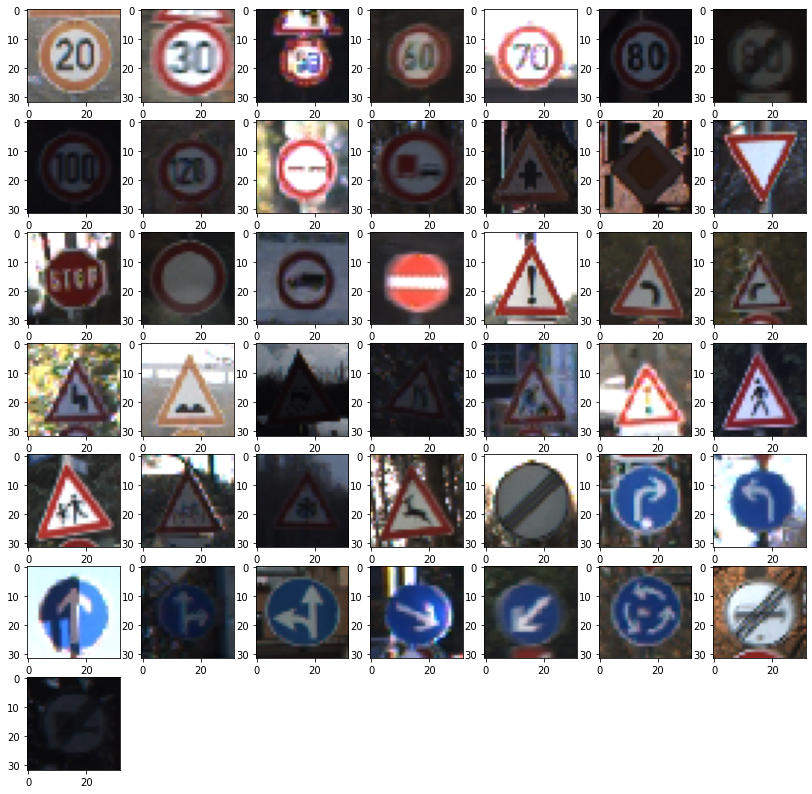

In [11]:
# Visualizing all the different Signs
img_dir = pathlib.Path(train_dir)
plt.figure(figsize=(14,14))
index = 0
for i in range(cat_num):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(img_width, img_height))
    plt.imshow(img)
plt.show()

## Class Distribution

In [12]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

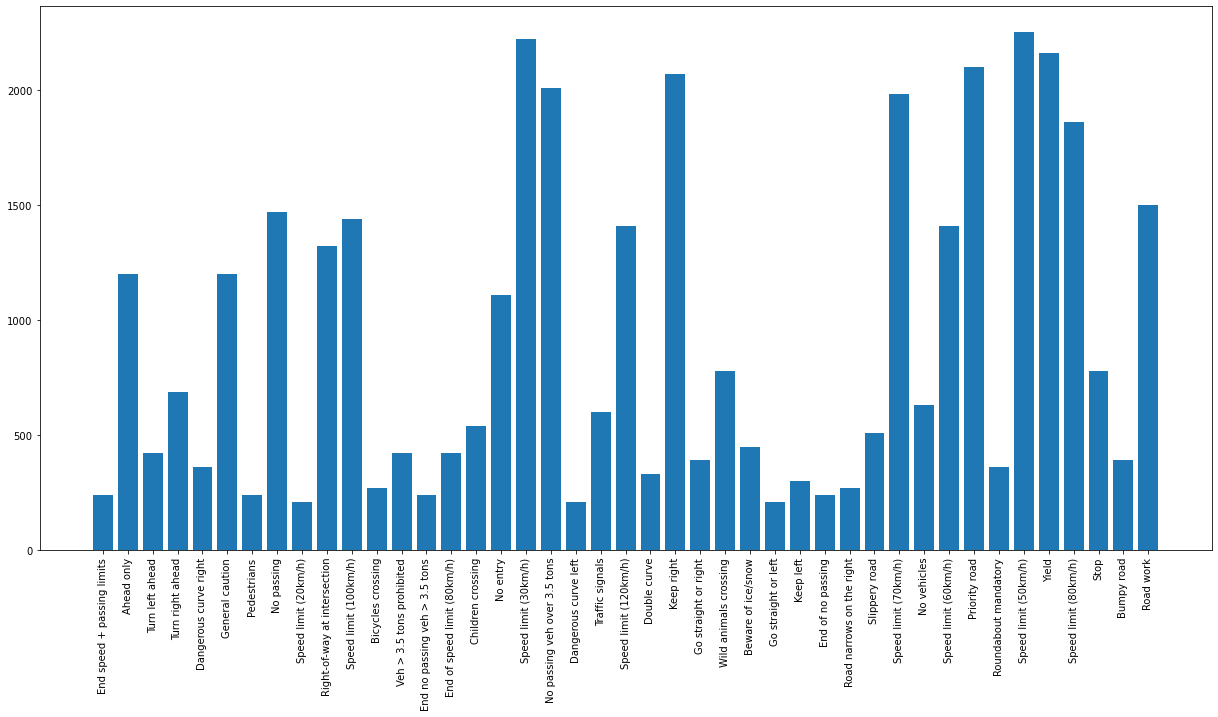

In [13]:
# determining the training data distribution per category
folders = next(os.walk(train_dir))[1]

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

## Analysis of the dataset

1. We can tell the image size is 
2. Some of the images have issues with low lighting / contrast / saturation which may become a problem for the model
3. The data is highly unbalanced

# Model Architectures

## Generic Paramters

In [14]:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

## Baseline

The first CNN we are going to build consists on the following: 
1. A Convolutional layer followed by a MaxPooling layer; 
2. A second Convolutional layer followed by another MaxPooling layer; 
3. A Flatten layer (this is the input layer for the fully connected part of the CNN); 
4. A Dense Layer (this is the first hidden layer for the fully connected part of the CNN)
5. A second Dense layer (this is the output layer for the fully connected part of the CNN).
<br>

Please be mindful regarding the details below:
- The first and second Convolutional layers should contain 32 neurons (filters), with a filter of size 3x3 and an input shape of 64x64x3;
- The first and second MaxPooling layer should have a size of 2x2;
- The first Dense layer should have 128 neurons and the activation function should be the relu, while the second Dense layer should contain 1 neuron and the softmax as the activation function.

In [15]:
baseline_model = Sequential()
# Refference: DLNN lecture week 6
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(32, 32, 3)))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
baseline_model.add(Flatten())
# MLP - hidden layer
baseline_model.add(Dense(units=128, activation=relu))
# MLP - output layer
baseline_model.add(Dense(units=43, activation=softmax))

# Check built model:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 128)               1

2022-01-07 21:51:03.933777: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training And Evaluating The Model

In [16]:
from tensorflow.keras import optimizers 

baseline_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [17]:
# Common attributes:
mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc']

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 5
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [19]:
# MLOps init and callback
wandb.init(name='CNN_TS_baseline_b256_e100' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)
/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


Epoch 1/100
5/5 [==============================] - 26s 6s/step - loss: 3.6809 - acc: 0.0562 - val_loss: 3.5976 - val_acc: 0.0553
Epoch 2/100
5/5 [==============================] - 24s 6s/step - loss: 3.5559 - acc: 0.0625 - val_loss: 3.4974 - val_acc: 0.0576
Epoch 3/100
5/5 [==============================] - 15s 4s/step - loss: 3.4643 - acc: 0.1039 - val_loss: 3.4466 - val_acc: 0.0924
Epoch 4/100
5/5 [==============================] - 20s 5s/step - loss: 3.4593 - acc: 0.1001 - val_loss: 3.3820 - val_acc: 0.1332
Epoch 5/100
5/5 [==============================] - 15s 3s/step - loss: 3.4037 - acc: 0.1969 - val_loss: 3.3217 - val_acc: 0.1953
Epoch 6/100
5/5 [==============================] - 16s 4s/step - loss: 3.2561 - acc: 0.2555 - val_loss: 3.2614 - val_acc: 0.1557
Epoch 7/100
5/5 [==============================] - 20s 5s/step - loss: 3.1711 - acc: 0.3039 - val_loss: 3.1465 - val_acc: 0.2250
Epoch 8/100
5/5 [==============================] - 16s 4s/step - loss: 3.0508 - acc: 0.3000 - val

acc,▁▁▁▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
time-elapsed,▁
val_acc,▁▁▂▂▂▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████
val_loss,██▇▇▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.93672
best_epoch,67
best_val_loss,0.76315
epoch,72
loss,0.26881


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7570/2990367024.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7570/2990367024.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


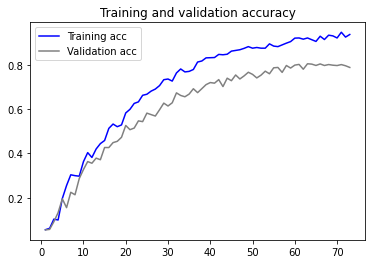

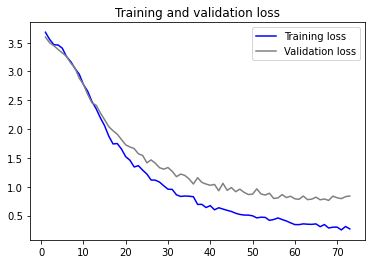

In [20]:
plot_results(history_baseline)

Confusion matrix, without normalization
[[ 0  4  4 ...  2  3  4]
 [ 3 40 39 ... 28 49 17]
 [ 2 35 36 ... 21 30 25]
 ...
 [ 0 32 42 ...  9 18 11]
 [ 0 25 27 ... 12 17 14]
 [ 0 22 33 ... 22 24 19]]


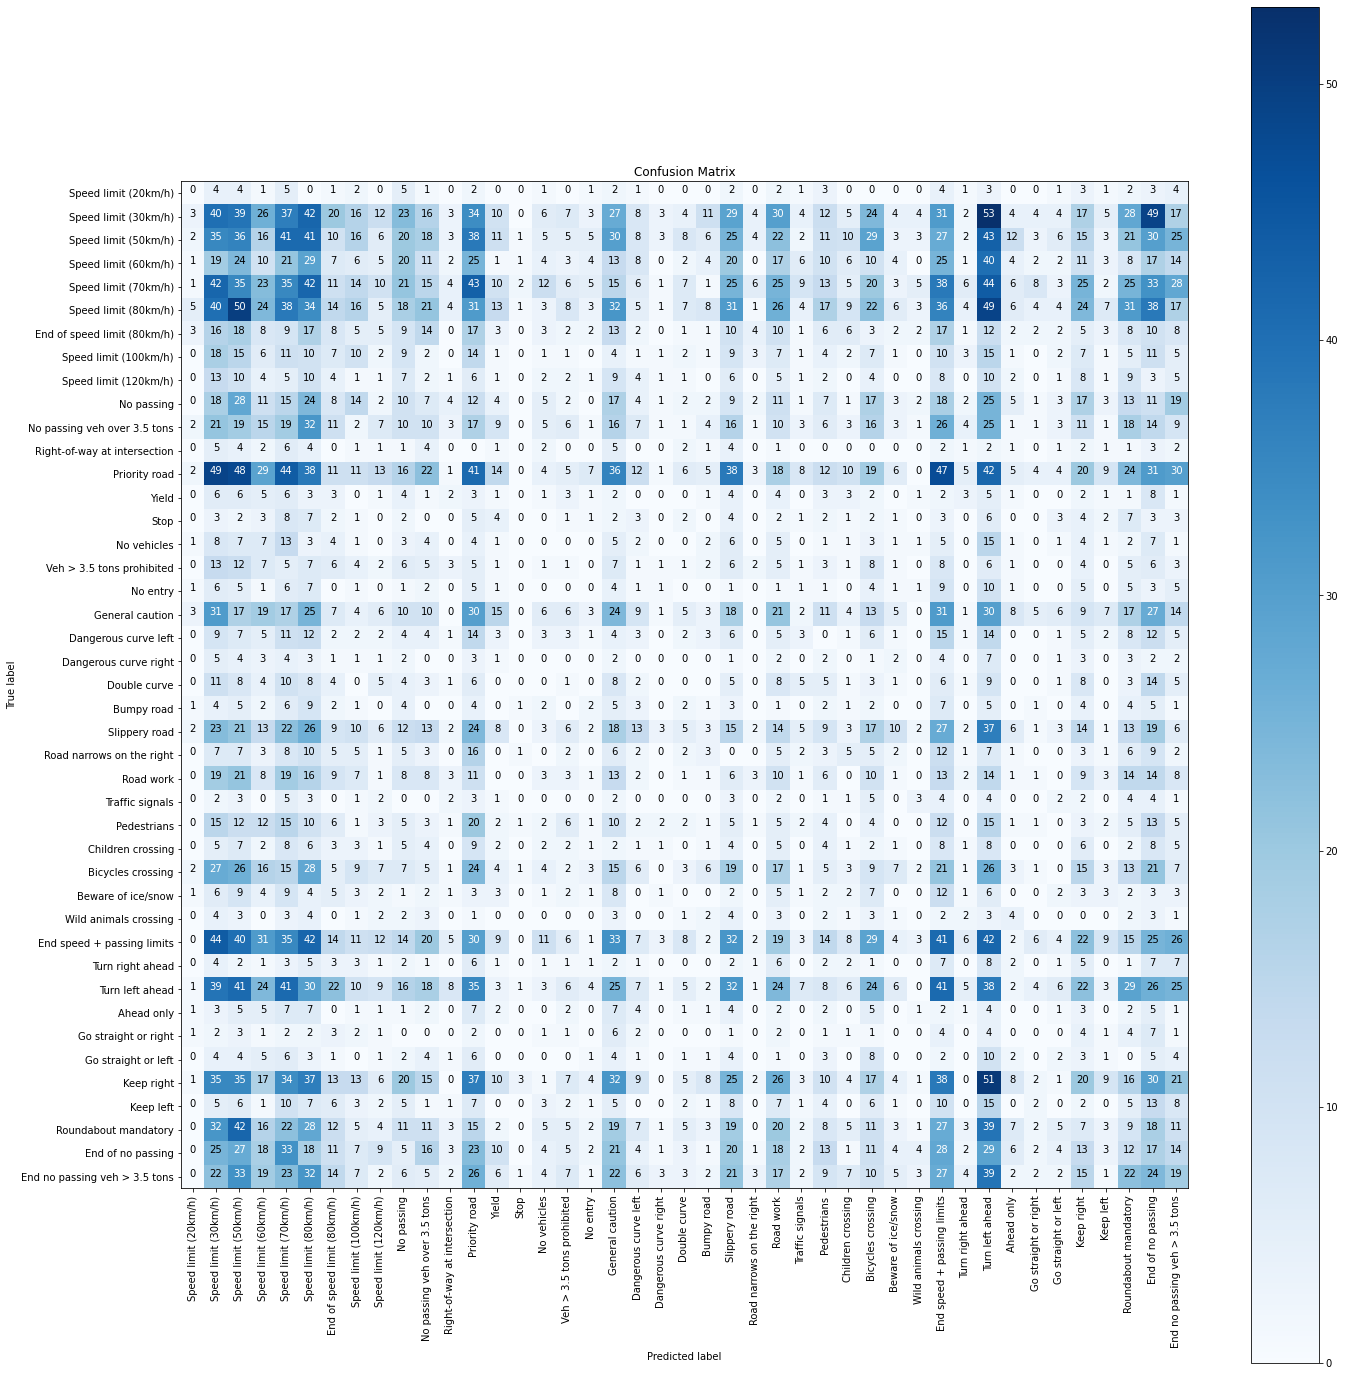

In [21]:
# predictions on Test data

Y_pred = baseline_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [36]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.00      0.00      0.00        34
         Speed limit (30km/h)       0.06      0.05      0.05       739
         Speed limit (50km/h)       0.05      0.05      0.05       750
         Speed limit (60km/h)       0.02      0.02      0.02       427
         Speed limit (70km/h)       0.05      0.05      0.05       692
         Speed limit (80km/h)       0.05      0.05      0.05       725
  End of speed limit (80km/h)       0.03      0.03      0.03       284
        Speed limit (100km/h)       0.05      0.04      0.05       231
        Speed limit (120km/h)       0.01      0.01      0.01       159
                   No passing       0.03      0.03      0.03       336
 No passing veh over 3.5 tons       0.03      0.03      0.03       306
 Right-of-way at intersection       0.00      0.00      0.00        65
                Priority road       0.05      0.06      0.06       664
     

Shape before entering the conv layer: (1, 32, 32, 3)


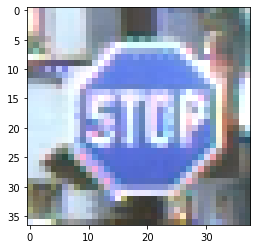

In [37]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 15, 15, 32)
(1, 13, 13, 32)
(1, 6, 6, 32)
(1, 1152)
(1, 128)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7570/2990367024.py:120: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


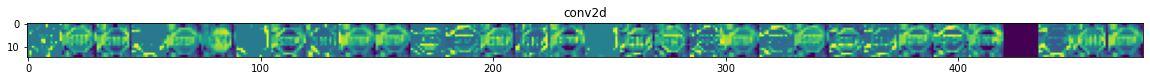

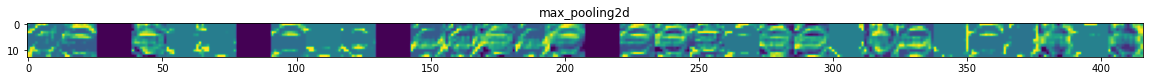

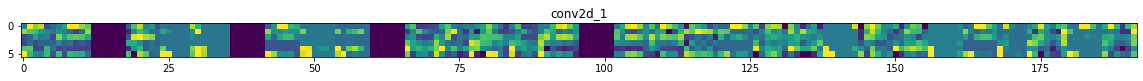

In [38]:
plot_feature_maps(baseline_model, img)

## Baseline - Kernel Size variations

In [39]:
# trying different kernel sizes
kernels = [5, 9, 13, 25]
models = [0] * (len(kernels))
mlops_config_kernels = models.copy()

In [40]:
# Generic parameters and call backs
from tensorflow.keras.callbacks import EarlyStopping

patience = 5
early_stopping = EarlyStopping (patience=patience, monitor='val_loss', mode='min', restore_best_weights=True)

### Training and Evaluation

In [41]:
history_kernels_kernels = [0] * (len(kernels))

for i in range(len(history_kernels_kernels)):
  # mlops
  start = timeit.default_timer()
  wandb.init(name='CNN_TS_baseline_kernels_b256_e100_' + str(i) , project='CNN_TS', config=mlops_config_kernels[i])
  # model fit
  history_kernels_kernels[i] = models[i].fit(
      train_generator,
      steps_per_epoch=mlops_config_kernels[i]['steps_per_epoch'],
      validation_data=val_generator,
      validation_steps=mlops_config_kernels[i]['validation_steps'],
      epochs=mlops_config_kernels[i]['epochs'],
      callbacks=[WandbCallback(),early_stopping])

  print('Model with filters {0:d}x{0:d}, epochs={1:d}, training accuracy={2:.5f}, validation loss={3:.5f}'.\
    format(mlops_config_kernels[i]['kernel_size'], mlops_config_kernels[i]['epochs'], max(history_kernels_kernels[i].history['acc']), max(history_kernels_kernels[i].history['val_loss'])))
  
  # mlops
  stop = timeit.default_timer()
  print('Time Elapsed: ', stop - start)
  wandb.log({'time-elapsed': stop - start})
  wandb.log({'training-accuracy': max(history_kernels_kernels[i].history['acc'])})
  wandb.log({'validation-loss': max(history_kernels_kernels[i].history['val_loss'])})
  wandb.log({'batch_size': mlops_config_kernels[i]['batch_size']})

  wandb.finish()


AttributeError: 'int' object has no attribute 'fit'

/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7465/2481331056.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7465/2481331056.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


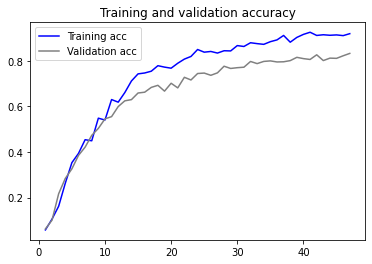

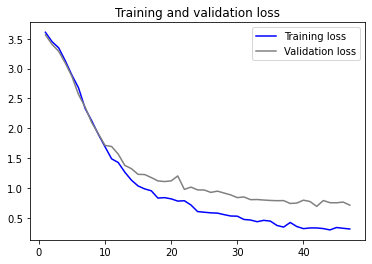

In [ ]:
# From the results, we can see that the best kernel size is 9
# Checking the resutls
plot_results(history_kernels_kernels[1])

Confusion matrix, without normalization
[[ 0  5  3 ...  2  3  4]
 [ 5 54 40 ... 26 24 21]
 [ 4 34 30 ... 23 26 26]
 ...
 [ 3 27 23 ... 18 19 16]
 [ 1 21 37 ... 25 12 10]
 [ 3 26 14 ... 13 13 20]]


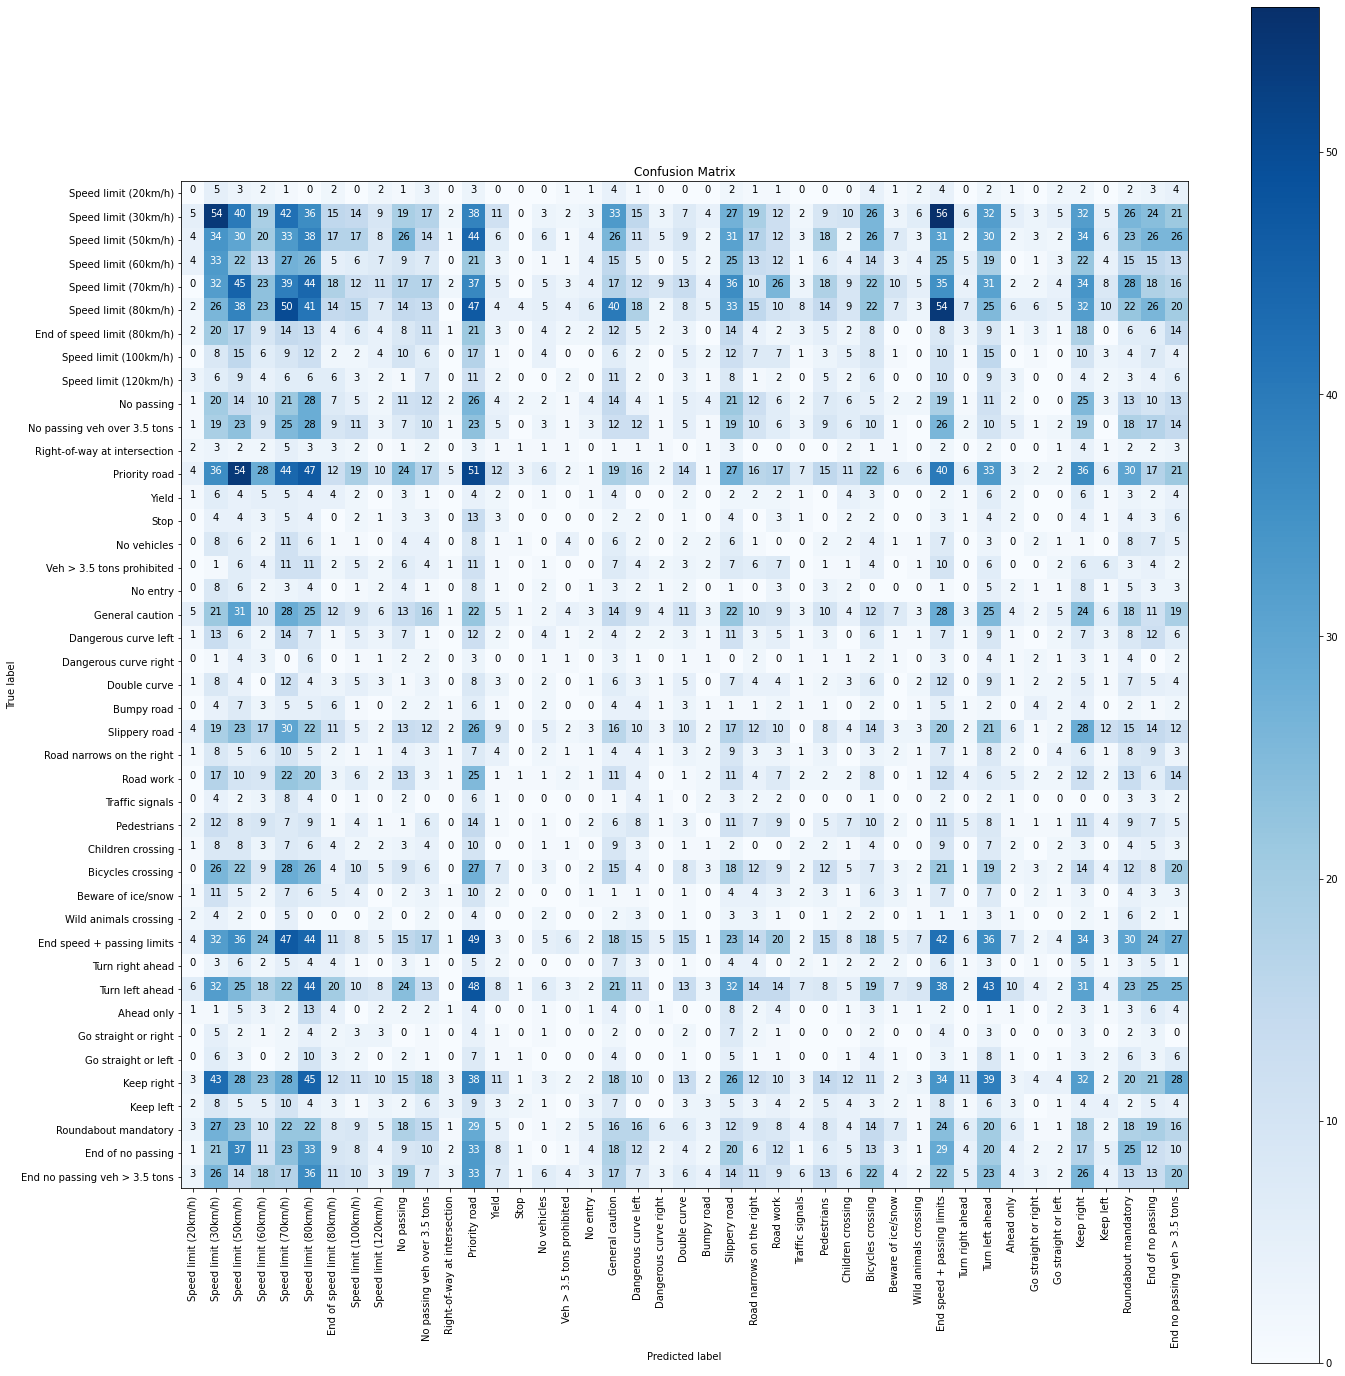

In [33]:
# predictions on Test data

Y_pred = models[1].predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

Shape before entering the conv layer: (1, 32, 32, 3)


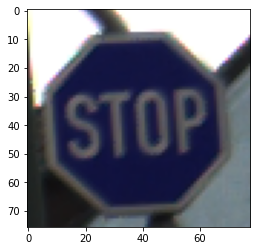

In [69]:
# plotting feature maps
# choosing a miss classified image
img = get_input_img(14,img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 12, 12, 32)
(1, 10, 10, 32)
(1, 5, 5, 32)
(1, 800)
(1, 500)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7465/2990367024.py:120: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


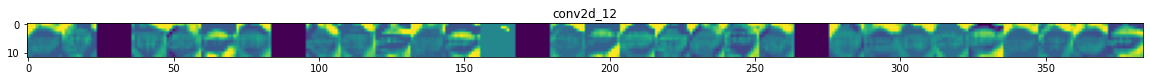

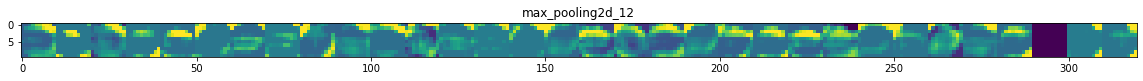

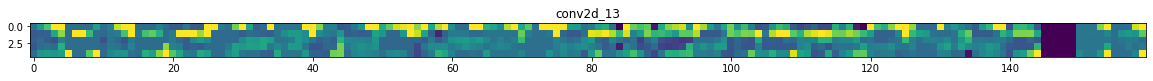

In [70]:
plot_feature_maps(models[1], img)

## 7 layer model

Refference: Masci, et al "A committee of neural networks for traffic sign classification" [1]

In [42]:
masci_model = Sequential()
# Refference: DLNN lecture week 6
masci_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
masci_model.add(Conv2D(filters=32, kernel_size = (4, 4), strides = (1,1), activation = relu, padding = 'valid'))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
masci_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
masci_model.add(Flatten())
# MLP - hidden layer
masci_model.add(Dense(units=200, activation=relu))
# MLP - output layer
masci_model.add(Dense(units=43, activation=softmax))

# Check built model:
masci_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 32)        16416     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 32)          9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 32)        

In [43]:
from tensorflow.keras import optimizers 

masci_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [44]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc']

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 5
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [46]:
# MLOps init and callback
wandb.init(name='CNN_TS_masci_b256_e100' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_masci_model = masci_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

Epoch 1/100
5/5 [==============================] - 22s 5s/step - loss: 3.7381 - acc: 0.0352 - val_loss: 3.6839 - val_acc: 0.0490
Epoch 2/100
5/5 [==============================] - 15s 4s/step - loss: 3.6112 - acc: 0.0656 - val_loss: 3.6281 - val_acc: 0.0578
Epoch 3/100
5/5 [==============================] - 14s 3s/step - loss: 3.5315 - acc: 0.0641 - val_loss: 3.5099 - val_acc: 0.0594
Epoch 4/100
5/5 [==============================] - 17s 4s/step - loss: 3.4994 - acc: 0.0695 - val_loss: 3.4590 - val_acc: 0.0664
Epoch 5/100
5/5 [==============================] - 17s 4s/step - loss: 3.4273 - acc: 0.1078 - val_loss: 3.4281 - val_acc: 0.1131
Epoch 6/100
5/5 [==============================] - 12s 3s/step - loss: 3.4119 - acc: 0.1586 - val_loss: 3.3768 - val_acc: 0.1354
Epoch 7/100
5/5 [==============================] - 11s 3s/step - loss: 3.3202 - acc: 0.1672 - val_loss: 3.3366 - val_acc: 0.1453
Epoch 8/100
5/5 [==============================] - 24s 6s/step - loss: 3.2543 - acc: 0.1961 - val

acc,▁▁▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
time-elapsed,▁
val_acc,▁▁▂▂▃▃▄▄▄▅▅▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████
val_loss,██▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
acc,0.87859
best_epoch,83
best_val_loss,1.0348
epoch,88
loss,0.43936


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7570/2990367024.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7570/2990367024.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


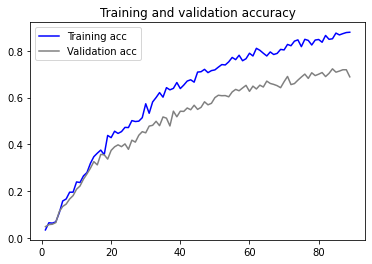

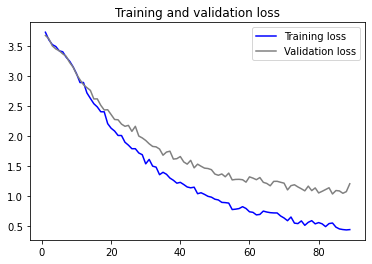

In [48]:
plot_results(history_masci_model)

Confusion matrix, without normalization
[[ 0  6  2 ...  1  2  3]
 [ 4 40 37 ... 20 40 33]
 [ 3 34 35 ... 20 22 28]
 ...
 [ 0 21 25 ... 18 20 22]
 [ 1 29 21 ... 12 20 15]
 [ 0 29 22 ... 13 20 15]]


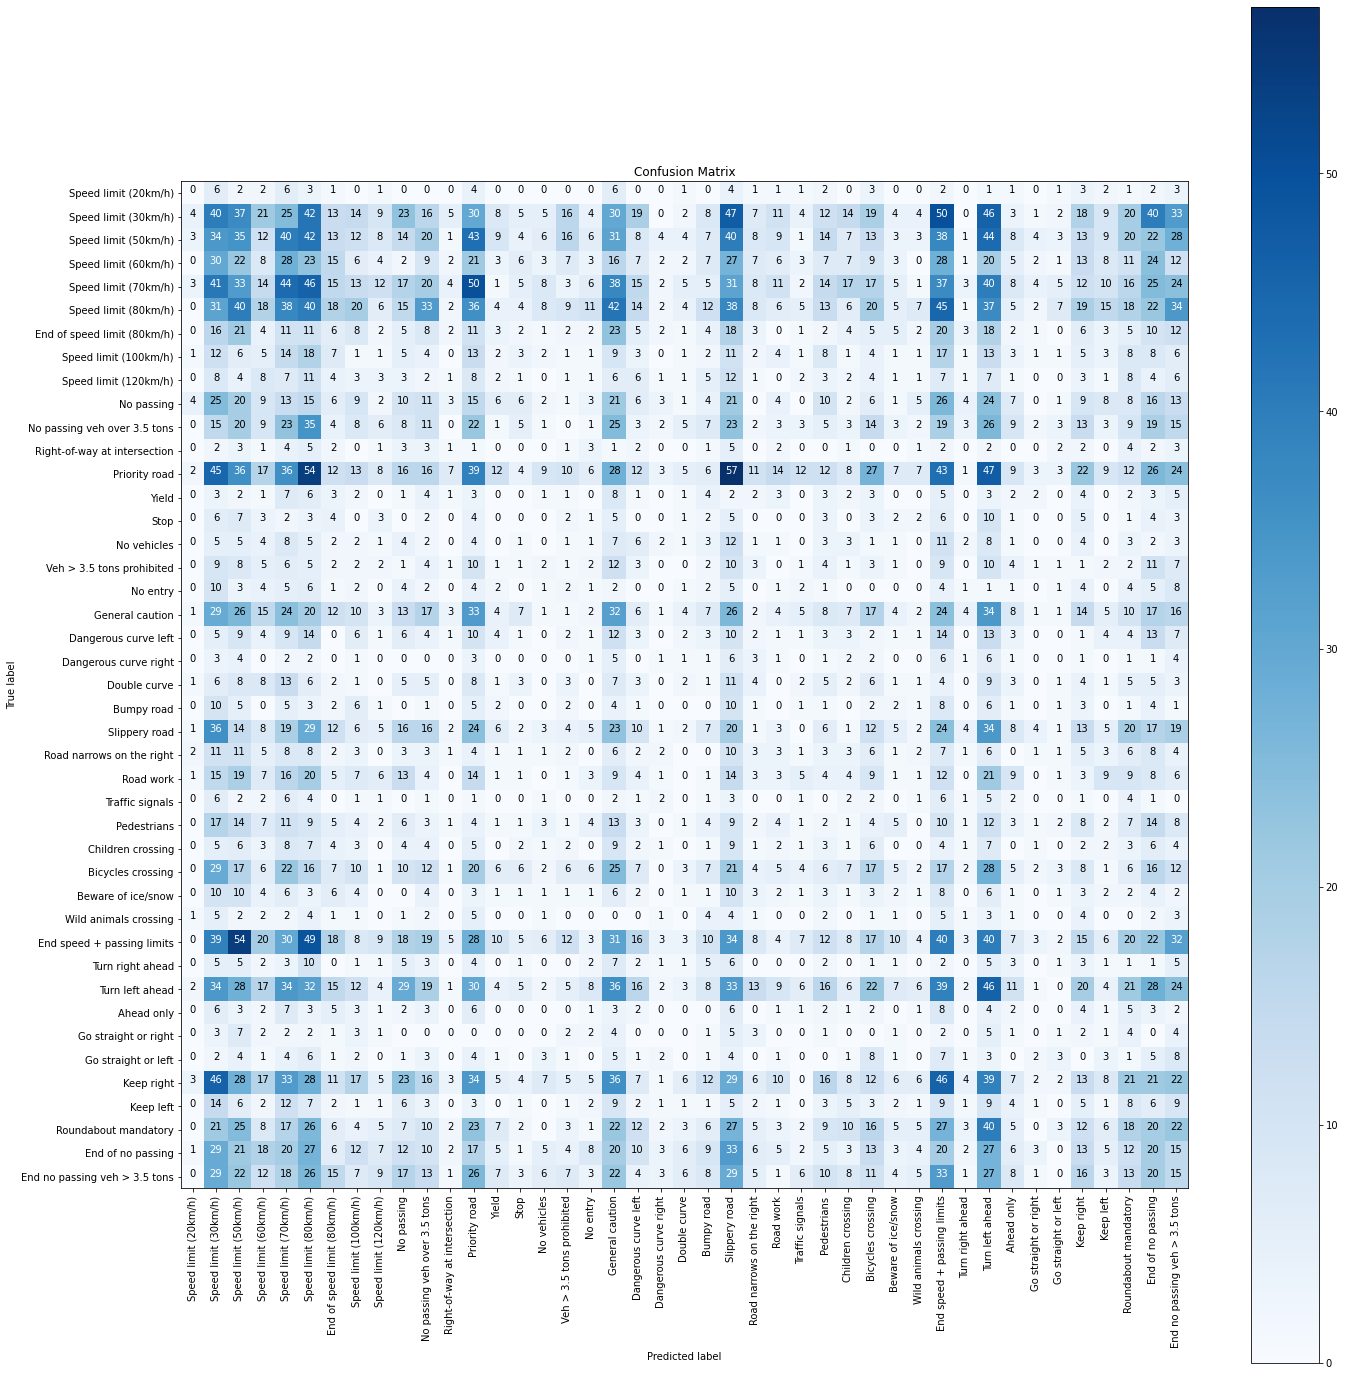

In [49]:
# predictions on Test data

Y_pred = masci_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [51]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.00      0.00      0.00        30
         Speed limit (30km/h)       0.06      0.05      0.05       753
         Speed limit (50km/h)       0.05      0.05      0.05       654
         Speed limit (60km/h)       0.02      0.03      0.02       317
         Speed limit (70km/h)       0.06      0.07      0.07       648
         Speed limit (80km/h)       0.06      0.05      0.06       731
  End of speed limit (80km/h)       0.02      0.02      0.02       266
        Speed limit (100km/h)       0.00      0.00      0.00       248
        Speed limit (120km/h)       0.02      0.02      0.02       132
                   No passing       0.03      0.03      0.03       328
 No passing veh over 3.5 tons       0.03      0.03      0.03       342
 Right-of-way at intersection       0.02      0.02      0.02        53
                Priority road       0.05      0.06      0.06       632
     

Shape before entering the conv layer: (1, 32, 32, 3)


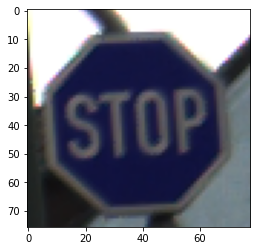

In [52]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 15, 15, 32)
(1, 12, 12, 32)
(1, 6, 6, 32)
(1, 4, 4, 32)
(1, 2, 2, 32)
(1, 128)
(1, 200)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7570/2990367024.py:120: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


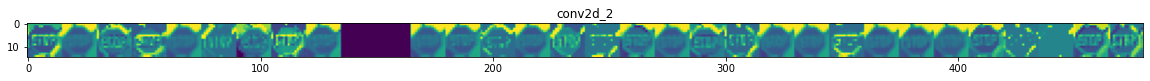

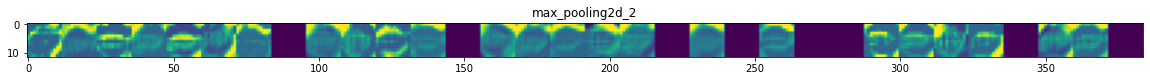

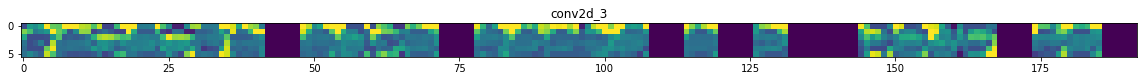

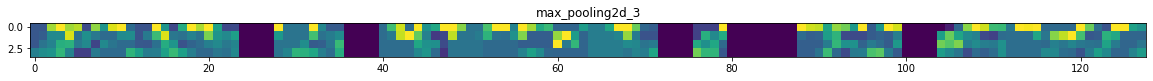

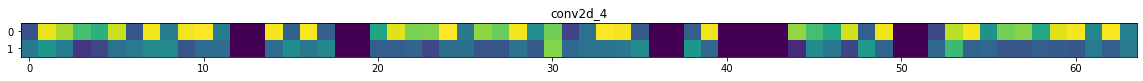

In [53]:
plot_feature_maps(masci_model, img)


## Small Scale Model

Refference: Chaudhari (et, al) "Traffic Sign Recognition Using Small-Scale Convolutional Neural Network"

In [55]:
lwm_model = Sequential()
# MLP - input layer
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model.add(Dropout(0.25))
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model.add(Dropout(0.25))
# MLP layer
lwm_model.add(Flatten())
lwm_model.add(Dense(units=256, activation=relu))
lwm_model.add(Dropout(0.25))
lwm_model.add(Dense(units=43, activation=softmax))


# Check built model:
lwm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                  

In [56]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc']

In [57]:
# adding f1-score
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average=None)

In [58]:
from tensorflow.keras import optimizers 

lwm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1 ])

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 10
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [60]:
# MLOps init and callback
wandb.init(name='CNN_TS_lwm_b256_e100' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_lwm_model = lwm_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

Epoch 1/100
5/5 [==============================] - 23s 5s/step - loss: 3.6991 - acc: 0.0469 - f1_score: 0.0104 - val_loss: 3.5918 - val_acc: 0.0541 - val_f1_score: 0.0024
Epoch 2/100
5/5 [==============================] - 22s 5s/step - loss: 3.5368 - acc: 0.0695 - f1_score: 0.0133 - val_loss: 3.4518 - val_acc: 0.1238 - val_f1_score: 0.0184
Epoch 3/100
5/5 [==============================] - 16s 4s/step - loss: 3.4704 - acc: 0.1031 - f1_score: 0.0225 - val_loss: 3.4117 - val_acc: 0.0973 - val_f1_score: 0.0252
Epoch 4/100
5/5 [==============================] - 17s 4s/step - loss: 3.3505 - acc: 0.1281 - f1_score: 0.0355 - val_loss: 3.3228 - val_acc: 0.1520 - val_f1_score: 0.0412
Epoch 5/100
5/5 [==============================] - 22s 5s/step - loss: 3.2756 - acc: 0.1406 - f1_score: 0.0421 - val_loss: 3.2605 - val_acc: 0.1354 - val_f1_score: 0.0414
Epoch 6/100
5/5 [==============================] - 23s 5s/step - loss: 3.2053 - acc: 0.1914 - f1_score: 0.0621 - val_loss: 3.1602 - val_acc: 0.20

acc,▁▁▂▃▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time-elapsed,▁
val_acc,▁▁▂▃▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇█████████████████████
val_loss,██▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.94609
best_epoch,94
best_val_loss,0.34232
epoch,99
loss,0.18404


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7570/2990367024.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7570/2990367024.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


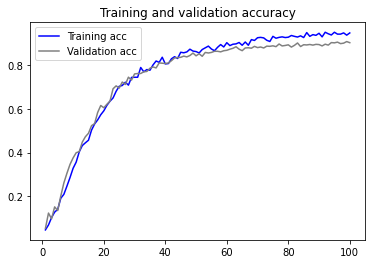

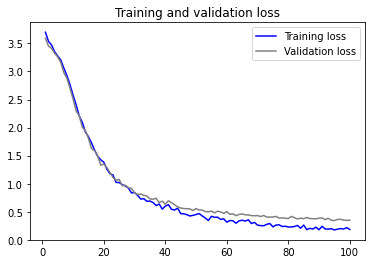

In [61]:
plot_results(history_lwm_model)

Confusion matrix, without normalization
[[ 0  3  3 ...  2  3  0]
 [ 0 37 42 ... 25 28 24]
 [ 2 45 37 ... 34 31 21]
 ...
 [ 0 31 17 ... 17 26 22]
 [ 0 34 23 ... 15 14 18]
 [ 1 28 18 ... 13 25 18]]


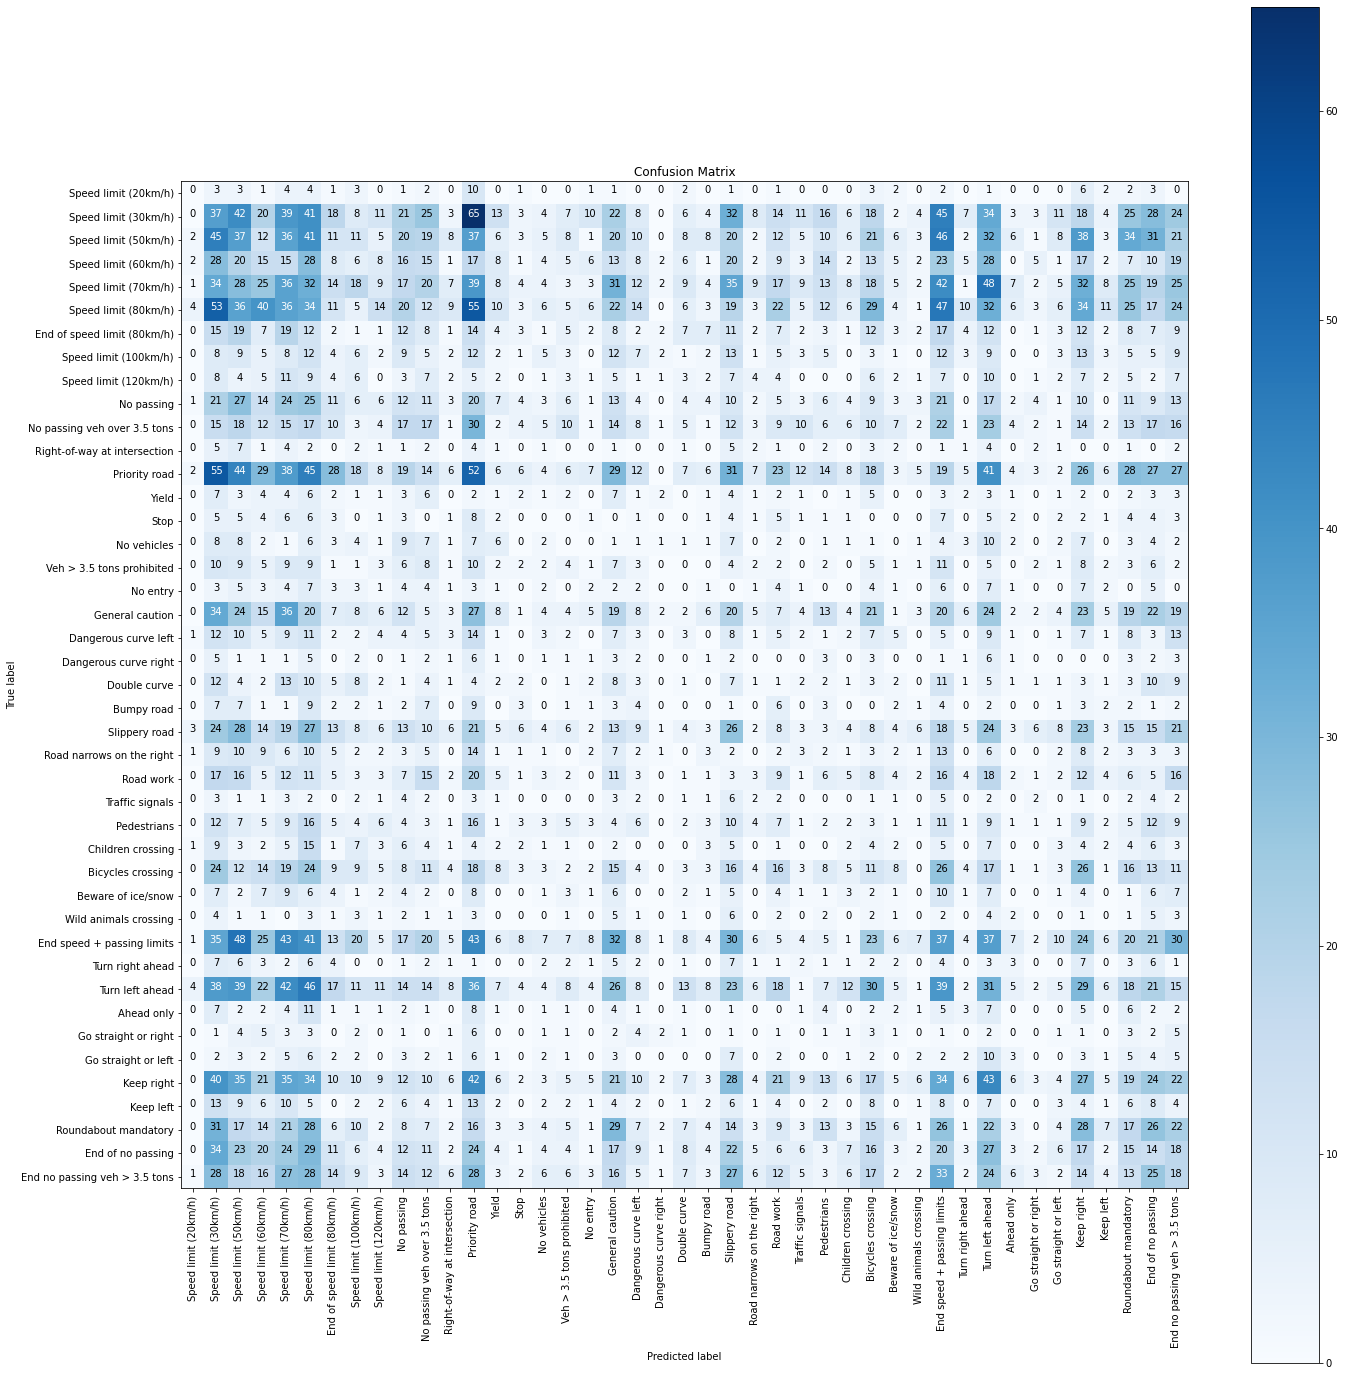

In [62]:
# predictions on Test data

Y_pred = lwm_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [66]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.00      0.00      0.00        24
         Speed limit (30km/h)       0.05      0.05      0.05       775
         Speed limit (50km/h)       0.06      0.06      0.06       654
         Speed limit (60km/h)       0.04      0.04      0.04       422
         Speed limit (70km/h)       0.05      0.05      0.05       667
         Speed limit (80km/h)       0.05      0.05      0.05       742
  End of speed limit (80km/h)       0.01      0.01      0.01       271
        Speed limit (100km/h)       0.03      0.03      0.03       236
        Speed limit (120km/h)       0.00      0.00      0.00       155
                   No passing       0.03      0.03      0.03       354
 No passing veh over 3.5 tons       0.04      0.05      0.05       341
 Right-of-way at intersection       0.00      0.00      0.00       103
                Priority road       0.07      0.07      0.07       780
     

Shape before entering the conv layer: (1, 32, 32, 3)


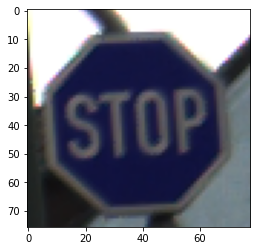

In [67]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 28, 28, 32)
(1, 14, 14, 32)
(1, 14, 14, 32)
(1, 12, 12, 32)
(1, 6, 6, 32)
(1, 6, 6, 32)
(1, 1152)
(1, 256)
(1, 256)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_7570/2990367024.py:120: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


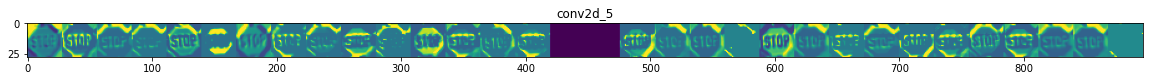

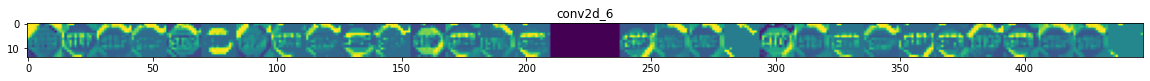

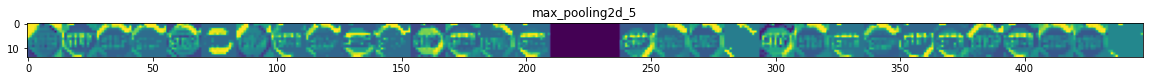

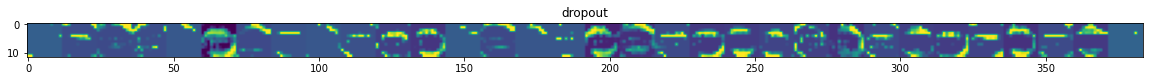

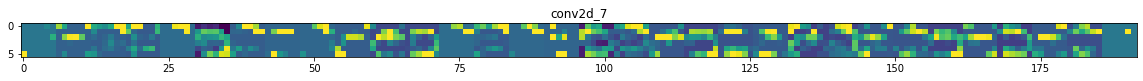

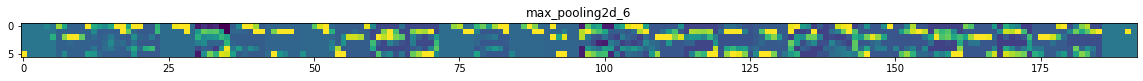

In [68]:
plot_feature_maps(lwm_model, img)

# Next Steps
- Plot the outputs of the several conv layers
- Check with different architectures:
  - See the used on the papers (masci done)
    - 2nd paper pending  - PA
    - consider a dropout layer with higher kernel values

- Check data augementation - PA
- Precision and recall metrics - JG
- Feature maps understanding  - AT / FB
- SHAP explainder - AT / FB

- Improve the acc/val loss graphs to plot multiple model curves

If time allows:
 - Check wandb sweep
 - consider different optimizers
 - consider different loss functions


# Batch Size and Epochs
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/


# 